# What's Cooking Multinomial Classification Challenge
![](images/cuisine.png)
<div>
![](images/fr.png) ![](images/us.png) ![](images/kr.png) ![](images/it.png) ![](images/in.png) ![](images/jp.png) ![](images/ru.png) ![](images/th.png) ![](images/es.png) ![](images/gr.png) ![](images/mx.png) ![](images/jm.png) ![](images/cn.png) ![](images/vn.png)
</div>
<br>
Categorize list of ingredients into cuisine types (20 labels).

https://www.kaggle.com/c/whats-cooking


# Admin/Configuration Console
<img src="images/admin.png" width="120">

In [53]:
# Main configuration parameters
dryRun = False
runParameterOptimization = False

if dryRun:
    nbPCAComponents = 2
    n_folds = 2
    early_stopping = 1
    maxIterations = 10
else:
    nbPCAComponents = 300
    n_folds = 4
    early_stopping = 10
    maxIterations = 100

# Load/Clean/Represent data
<img src="images/broom.png" width="150">

In [3]:
%matplotlib inline
import pandas as pd

pd.set_option('display.max_colwidth', 1000)
rawTrain = pd.read_json('data/train.json')
rawTrain = rawTrain.drop(['id'], axis=1)

if dryRun:
    rawTrain = rawTrain.head(1000)

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i051796/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/i051796/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/i051796/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# data cleansing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

stopWords = set(stopwords.words('english'))

# JJ: adjective
stopTypes = ['JJ', 'POS','UH','PRP' ,'DT', 'CC']

showDiff = True
showStopFreqWords = False
showStopTypeWords = True
showCount = 0
maxShowCount = 5
spaceEscapeToken ="xxxx"

def cleanIngredients(ingredients):
    cleanIngredients = list()
    for ingredient in ingredients:
        cleanIngredient = ingredient.lower()
        # remove special characters (only alphabets are kept)
        cleanIngredient = re.sub(r"[^a-zA-Z\sçàéè\-î]+", '', cleanIngredient)
        # remove usless spaces
        cleanIngredient = re.sub(r"\s{2,}", ' ', cleanIngredient)
        cleanIngredient = re.sub(r"^\s", '', cleanIngredient)
        cleanIngredient = re.sub(r"\s$", '', cleanIngredient)
        # remove usual stop words
        words = word_tokenize(cleanIngredient)
        stopFreqWords = [word for word in words if word not in stopWords]
        if showStopFreqWords and len(stopFreqWords) != len(words):
            print("{} -> {}".format(words, stopFreqWords))
        
        # remove adjective (qualification) => currently disable
        if False:
            words = nltk.pos_tag(stopFreqWords)
            stopTypeWords = [w for w, wtype in words if wtype not in stopTypes]            
            if showStopTypeWords and len(stopTypeWords) != len(stopFreqWords):
                print("{} -> {}".format(stopFreqWords, stopTypeWords)) 
        else:
            stopTypeWords = stopFreqWords
            
        cleanIngredient = spaceEscapeToken.join(stopTypeWords)
        # final final difference if any
        global showCount
        if showDiff and showCount < maxShowCount and cleanIngredient != ingredient:
            showCount = showCount + 1
            print("{} -> {}".format(ingredient, cleanIngredient))
            if showCount == maxShowCount:
                print("....")
        
        cleanIngredients.append(cleanIngredient)
    res = ",".join(cleanIngredients)
    return res

print("Cleaning ingredient texts...\n")
%time rawTrain.ingredients = rawTrain.ingredients.map(lambda x: cleanIngredients(x))

Cleaning ingredient texts...

romaine lettuce -> romainexxxxlettuce
black olives -> blackxxxxolives
grape tomatoes -> grapexxxxtomatoes
purple onion -> purplexxxxonion
garbanzo beans -> garbanzoxxxxbeans
....
CPU times: user 25.2 s, sys: 26 ms, total: 25.2 s
Wall time: 25.2 s


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = rawTrain.ingredients.tolist()
vectorizer = CountVectorizer()
print("Vectorizing training dataset...\n")
%time v = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
columnNames = list(map(lambda x: x.replace(spaceEscapeToken, " "), vectorizer.get_feature_names()))
vectorizedTrain = pd.DataFrame(v.toarray(), columns = columnNames)
vectorizedTrain['cuisine'] = rawTrain.cuisine
vectorizedTrain.head(3)

Vectorizing training dataset...

CPU times: user 365 ms, sys: 6.63 ms, total: 372 ms
Wall time: 371 ms


,abalone,abbamele,absinthe,abura age,acai juice,accent,accent seasoning,accompaniment,achiote,achiote paste,...,zaatar,zatarains creole seasoning,zatarains jambalaya mix,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,greek
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,filipino


# Explore data
<img src="images/explore.png" width="100">

In [7]:
cuisines = rawTrain.cuisine.unique().tolist()

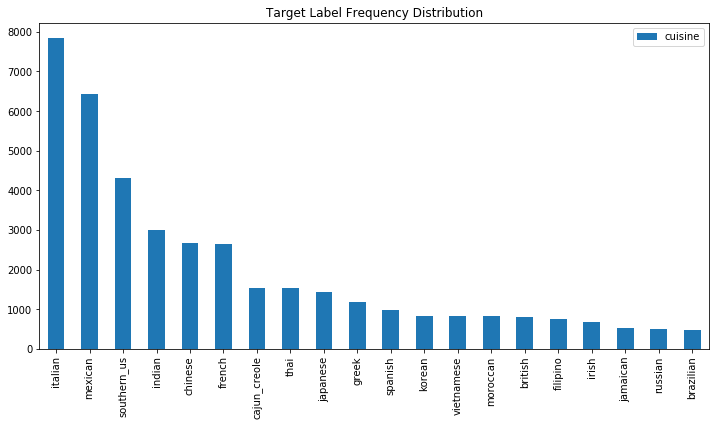

In [8]:
pd.DataFrame(pd.Series(rawTrain.cuisine).value_counts()).plot.bar(figsize=(12,6), title='Target Label Frequency Distribution')
pass

## Analyze ingredients
<img src="images/food2.png" width="150">

In [9]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [10]:
aggregatedCount = pd.DataFrame(vectorizedTrain.groupby("cuisine", as_index=False).sum())
%time unpivotTrain = pd.melt(aggregatedCount, id_vars=[('cuisine')])

topCount = 30

topIngredientPerCuisine = pd.DataFrame(unpivotTrain.groupby(['cuisine'])['value'].nlargest(topCount))
topIngredientPerCuisine.reset_index(inplace=True)
topIngredientPerCuisine = topIngredientPerCuisine.set_index("level_1").join(unpivotTrain['variable'])[['cuisine','variable','value']]
topIngredientPerCuisine.reset_index(inplace=True)
topIngredientPerCuisine.drop(columns=['level_1'], inplace=True)
topIngredientPerCuisine = topIngredientPerCuisine.rename(axis=1, mapper = {'value':'count', 'variable':'ingredient'})

CPU times: user 45.8 ms, sys: 211 µs, total: 46.1 ms
Wall time: 7.69 ms


In [11]:
print("\nTop ingredients per cuisine\n")
#topIngredientPerCuisine.head(20 * topCount)
chunk = list()
for cuisine in cuisines:
    if len(chunk) == 4:
        display(multi_table(chunk))
        chunk  = list()
    else:
        chunk.append(topIngredientPerCuisine[topIngredientPerCuisine.cuisine == cuisine].head(10))

if len(chunk) > 0:
    display(multi_table(chunk))


Top ingredients per cuisine



,cuisine,ingredient,count
180,greek,salt,572
181,greek,olive oil,504
182,greek,dried oregano,267
183,greek,garlic cloves,254
184,greek,feta cheese crumbles,252
185,greek,extra,229
186,greek,virgin olive oil,229
187,greek,fresh lemon juice,222
188,greek,ground black pepper,221
189,greek,garlic,216


,cuisine,ingredient,count
510,spanish,salt,461
511,spanish,olive oil,387
512,spanish,garlic cloves,290
513,spanish,virgin olive oil,257
514,spanish,extra,255
515,spanish,onions,253
516,spanish,water,158
517,spanish,tomatoes,151
518,spanish,ground black pepper,149
519,spanish,red bell pepper,142


,cuisine,ingredient,count
540,thai,fish sauce,625
541,thai,garlic,414
542,thai,salt,396
543,thai,coconut milk,353
544,thai,vegetable oil,335
545,thai,soy sauce,332
546,thai,sugar,330
547,thai,water,310
548,thai,garlic cloves,299
549,thai,fresh lime juice,273


,cuisine,ingredient,count
330,japanese,soy sauce,561
331,japanese,salt,422
332,japanese,mirin,402
333,japanese,sugar,401
334,japanese,water,383
335,japanese,sake,289
336,japanese,rice vinegar,261
337,japanese,vegetable oil,245
338,japanese,scallions,229
339,japanese,ginger,190


In [23]:
invertedRank = topIngredientPerCuisine.groupby(['cuisine'])['count'].rank(ascending=True)
topIngredientPerCuisine['invertedRank'] = invertedRank
topIngredientPerCuisine.head(3)

,cuisine,ingredient,count,invertedRank
0,brazilian,salt,194,30.0
1,brazilian,onions,133,29.0
2,brazilian,olive oil,118,28.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

topCountIntersectHeatMap = topIngredientPerCuisine.copy()
topCountIntersectHeatMap['fakeKey'] = 0
topCountIntersectHeatMap = topCountIntersectHeatMap.merge(topCountIntersectHeatMap, on='fakeKey', how='outer')

topCountIntersectHeatMap['count'] = topCountIntersectHeatMap.apply(lambda x:
  (x.invertedRank_x + x.invertedRank_y) if x.ingredient_x == x.ingredient_y else 0, axis=1
)
topCountIntersectHeatMap = pd.DataFrame(topCountIntersectHeatMap.groupby(['cuisine_x','cuisine_y'])['count'].sum())
topCountIntersectHeatMap.reset_index(inplace=True)

maxScore = 2 * np.arange(1,topCount+1).sum()
topCountIntersectHeatMap['count'] = topCountIntersectHeatMap['count'].map(lambda x : np.rint(100 * float(x)/float(maxScore)))
pivot = topCountIntersectHeatMap.pivot(index='cuisine_x', columns='cuisine_y', values='count')

Top Ingredient Cross Match


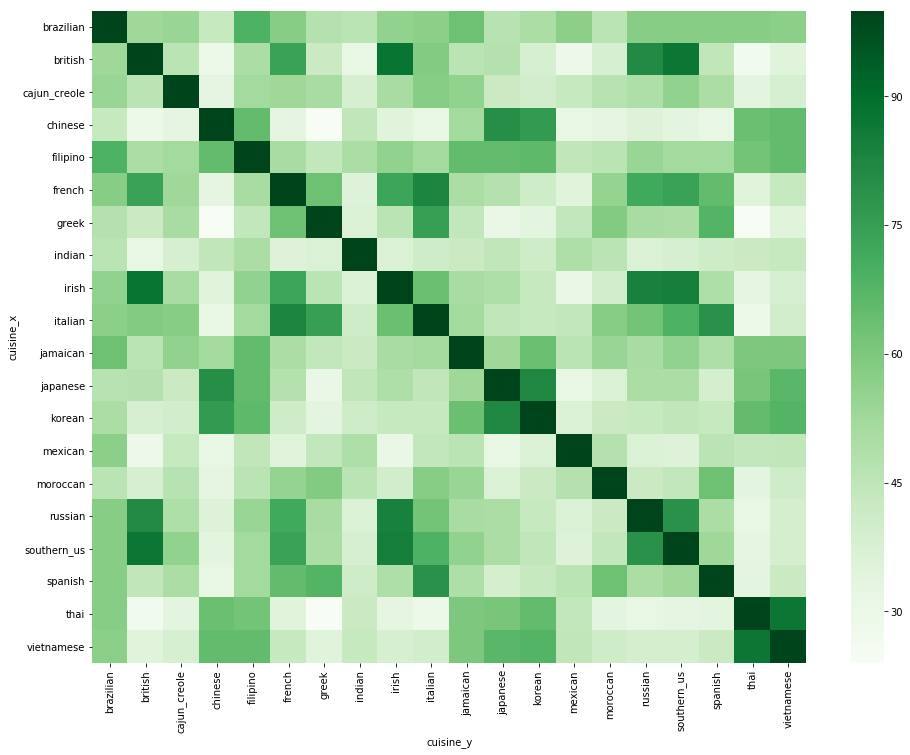

In [32]:
print('Top Ingredient Cross Match')
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(pivot, cmap="Greens")
pass

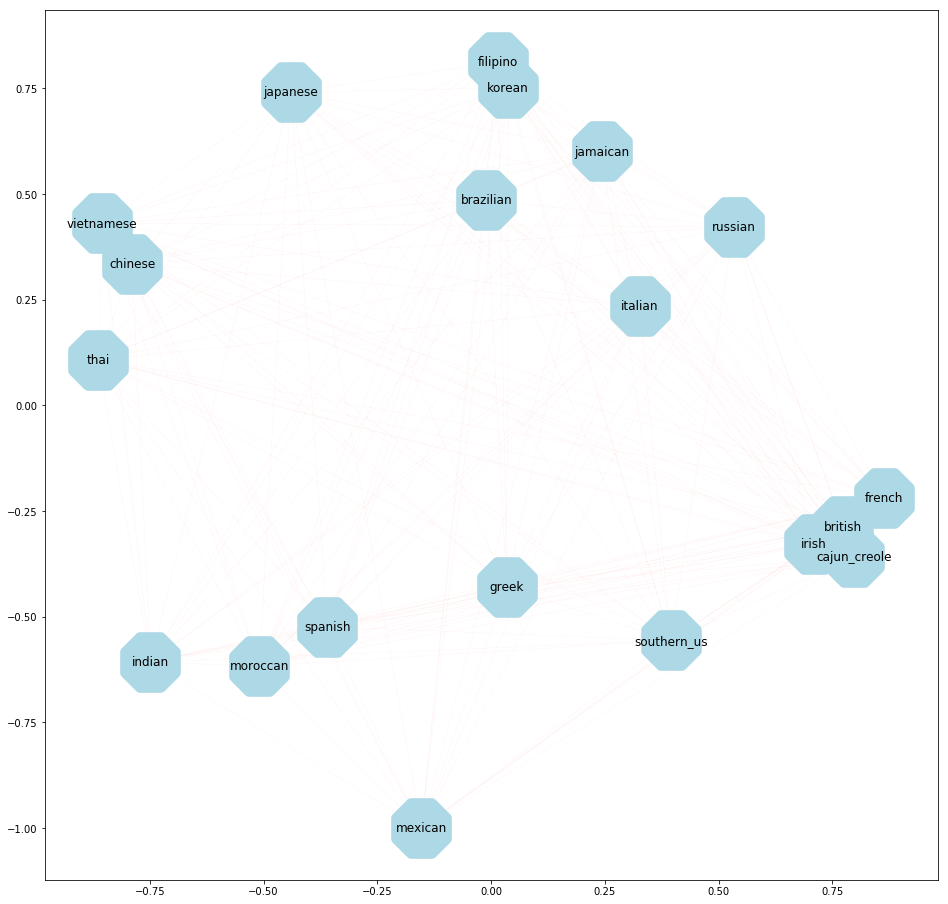

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

pivot2 = pivot.copy()
for col in pivot2.columns:
    pivot2[col] = pivot2[col].map(lambda x : 40*x)
g = nx.from_pandas_adjacency(pivot2)

fig, ax = plt.subplots(1, 1, figsize=(16, 16));
nx.draw_networkx(g, ax=ax,style='dotted',width=.05,node_color='lightblue',node_size=3000, edge_color='r',font_color='k', linewidths=10, node_shape='8')

In [15]:
# build distinct words from ingredient names
trainVocabularies = list()
for ingredient in columnNames:
    trainVocabularies.append(ingredient.split(" "))
# flatten list of lists
trainVocabularies = pd.DataFrame([item for sublist in trainVocabularies for item in sublist], columns=['word'])
trainVocabularies['count'] = 1
hist = trainVocabularies.groupby(by=['word']).count()
print("number of distinct ingredient words = {}".format(len(trainVocabularies)))
hist = hist.sort_values('count', ascending=False).head(10)
chickenIngredients = list(filter(lambda x: 'chicken' in x, columnNames))
chickenIngredients = pd.DataFrame(chickenIngredients, columns=['chicken based ingredient'])
display(multi_table([hist, chickenIngredients.head(10)] ))

number of distinct ingredient words = 15686


,count
word,
sauce,196
cheese,196
chicken,188
fat,154
mix,117
cream,113
sodium,111
rice,107
fresh,100


# Prepare data
<img src="images/pan.png" width="150">

In [16]:
# apply TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

features = vectorizedTrain.drop(columns=['cuisine'])

tfIdf = TfidfTransformer()
print("Applying TF-DIF transform...\n")

%time rescaledFeatures = tfIdf.fit_transform(features)

rescaledFeatures= pd.DataFrame(rescaledFeatures.toarray())

rescaledFeatures.head(3)

Applying TF-DIF transform...

CPU times: user 2.48 s, sys: 3.7 ms, total: 2.49 s
Wall time: 2.49 s


,0,1,2,3,4,5,6,7,8,9,...,6728,6729,6730,6731,6732,6733,6734,6735,6736,6737
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# apply a PCA
from sklearn.decomposition import PCA

uniqueTrainIngredients = columnNames

pca = PCA(n_components=nbPCAComponents)

print("Applying PCA transform from {} to {} dimension...\n".format(len(uniqueTrainIngredients), nbPCAComponents))
%time pcaFeatures = pca.fit_transform(rescaledFeatures)

pcaFeatures = pd.DataFrame(pcaFeatures)
pcaFeatures.head(3)

Applying PCA transform from 6738 to 300 dimension...

CPU times: user 1min 25s, sys: 3.79 s, total: 1min 29s
Wall time: 17.4 s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.080482,-0.022362,-0.032018,0.003633,-0.031770,0.033845,-0.064996,0.054832,0.138700,0.025738,...,0.024029,-0.001036,-0.021350,-0.017895,-0.029919,-0.019156,-0.020010,0.032276,-0.065720,0.006050
1,0.067393,-0.017626,-0.071741,-0.029016,-0.008896,0.115094,-0.073017,0.010152,-0.094674,0.109563,...,0.021158,0.020277,-0.100320,-0.015178,-0.041362,0.061173,-0.078096,-0.012609,0.004876,0.036544
2,0.020879,0.066977,-0.096002,-0.071671,-0.094304,0.127012,-0.111040,0.050188,-0.034673,0.027550,...,-0.008989,-0.001444,-0.000471,-0.003866,-0.008412,-0.003715,-0.007443,-0.009532,0.002755,-0.019864


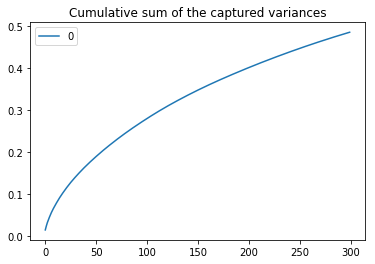

In [18]:
pd.DataFrame(pca.explained_variance_ratio_.cumsum()).plot(title='Cumulative sum of the captured variances')
pass

In [19]:
rawTrain['countIngr'] = rawTrain.ingredients.map(lambda x : len(x))

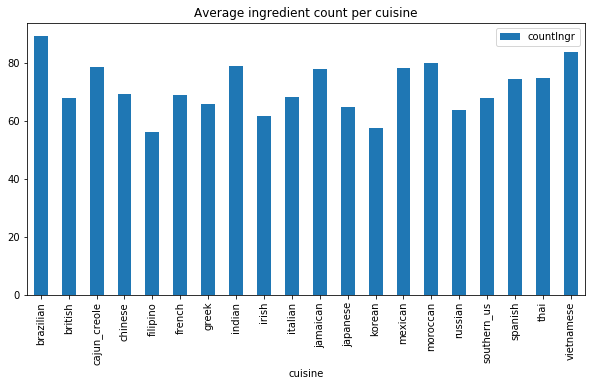

In [20]:
rawTrain[['countIngr','cuisine']].groupby(by='cuisine').std().plot(title="Average ingredient count per cuisine", figsize=(10,5), kind='bar')

# Learn from data
<div style="vertical-align:middle">
    <img src="images/learn.png" width="150" >
    <img src="images/xgb.png" width="200">
</divs>

In [21]:
import xgboost as xgb

from sklearn import preprocessing

# encode the target numerically
labelEncoder = preprocessing.LabelEncoder()
y = labelEncoder.fit_transform(rawTrain.cuisine)

## Optimize hyper-parameters
<img src="images/optim.png" width="100">

In [55]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

if runParameterOptimization:
    print("Optimizing XGBoost parameters...\n")

    classifier = xgb.XGBClassifier(
        early_stopping_rounds = early_stopping,
        n_estimators= maxIterations,
        nthread=5,
        tree_method = 'hist',
        objective= 'multi:softprob',
        silent=False
    )

    # parameter grid
    params = {
        'learning_rate': [.02,.05,.1],
        'colsample_bytree': [0.6,1.0],
        'max_depth': [3,5,8]
    }

    # target distrib is imbalanced
    skf = StratifiedKFold(
        n_splits=n_folds,
        shuffle = True,
        random_state = 1960)

    randomSearch = RandomizedSearchCV(
        classifier,
        param_distributions=params,
        n_iter=12,
        scoring='accuracy',
        n_jobs=2,
        cv=skf.split(pcaFeatures,y),
        verbose=1,
        random_state=1960
    )

    %time randomSearch.fit(pcaFeatures, y)
    
    print("Best average accuracy on validation fold = {}".format(max(randomSearch.cv_results_['mean_test_score'])))
    
    best_learning_rate = randomSearch.best_params_['learning_rate']
    best_colsample_bytree = randomSearch.best_params_['colsample_bytree']
    best_max_depth = randomSearch.best_params_['max_depth']
else:
    print("Best average accuracy on validation fold = {}".format(0.6882))
    
    best_learning_rate = 0.1
    best_colsample_bytree = 0.6
    best_max_depth = 8

print("")
print("Optimal learning rate = {}".format(best_learning_rate))
print("Optimal column sample by tree = {}".format(best_colsample_bytree))
print("Optimal max depth = {}".format(best_max_depth))

Best average accuracy on validation fold = 0.6882

Optimal learning rate = 0.1
Optimal column sample by tree = 0.6
Optimal max depth = 8


## Build final model
<img src="images/build.png" width="120">

In [ ]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

print("Fitting the final XGBoost model...\n")

classifier = xgb.XGBClassifier(
    learning_rate= best_learning_rate,
    colsample_bytree= best_colsample_bytree,
    max_depth= best_max_depth, 
    tree_method = 'hist',
    n_estimators= maxIterations,
    nthread=10,
    objective= 'multi:softprob',
    silent=True
)

pcaFeatures_train, pcaFeatures_test, y_train, y_test = train_test_split(pcaFeatures, y, test_size=0.20, random_state=1960)

%time classifier.fit(pcaFeatures_train,y = y_train,verbose = False,eval_metric = 'merror', early_stopping_rounds = early_stopping, eval_set = [(pcaFeatures_train, y_train), (pcaFeatures_test, y_test)])
classifier

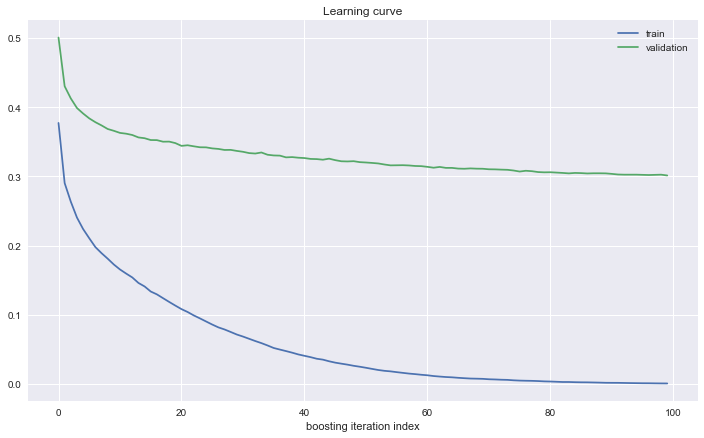

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.plot()
trainError = classifier.evals_result()['validation_0']['merror']
validationError = classifier.evals_result()['validation_1']['merror']
learningCurve = pd.DataFrame()
learningCurve['train'] = trainError
learningCurve['validation'] = validationError
learningCurve["boosting iteration index"] = learningCurve.index
learningCurve.set_index("boosting iteration index",drop=True,inplace=True)
learningCurve.plot(figsize=(12,7), title="Learning curve")
pass

In [ ]:
import pickle
#pickle.dump(classifier, open("xgboost_model.dat", "wb"))
#classifier = pickle.load(open("xgboost_model.dat", "rb"))

# Measure performance
<img src="images/perf.png" width="170">

In [89]:
print("Applying the model to the training dataset...\n")
%time yDecision_test = classifier.predict(pcaFeatures_test)

Applying the model to the training dataset...

CPU times: user 4.22 s, sys: 53.3 ms, total: 4.27 s
Wall time: 3.25 s


In [90]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

          0       0.85      0.23      0.36       102
          1       0.62      0.18      0.28       180
          2       0.83      0.59      0.69       332
          3       0.73      0.85      0.79       542
          4       0.72      0.47      0.57       144
          5       0.48      0.48      0.48       503
          6       0.85      0.52      0.64       227
          7       0.84      0.84      0.84       616
          8       0.66      0.25      0.36       115
          9       0.65      0.91      0.76      1522
         10       0.93      0.36      0.52       112
         11       0.83      0.56      0.67       268
         12       0.78      0.55      0.64       139
         13       0.82      0.88      0.85      1308
         14       0.79      0.49      0.60       174
         15       0.89      0.18      0.30        88
         16       0.55      0.75      0.64       879
         17       0.76      0.16      0.27   

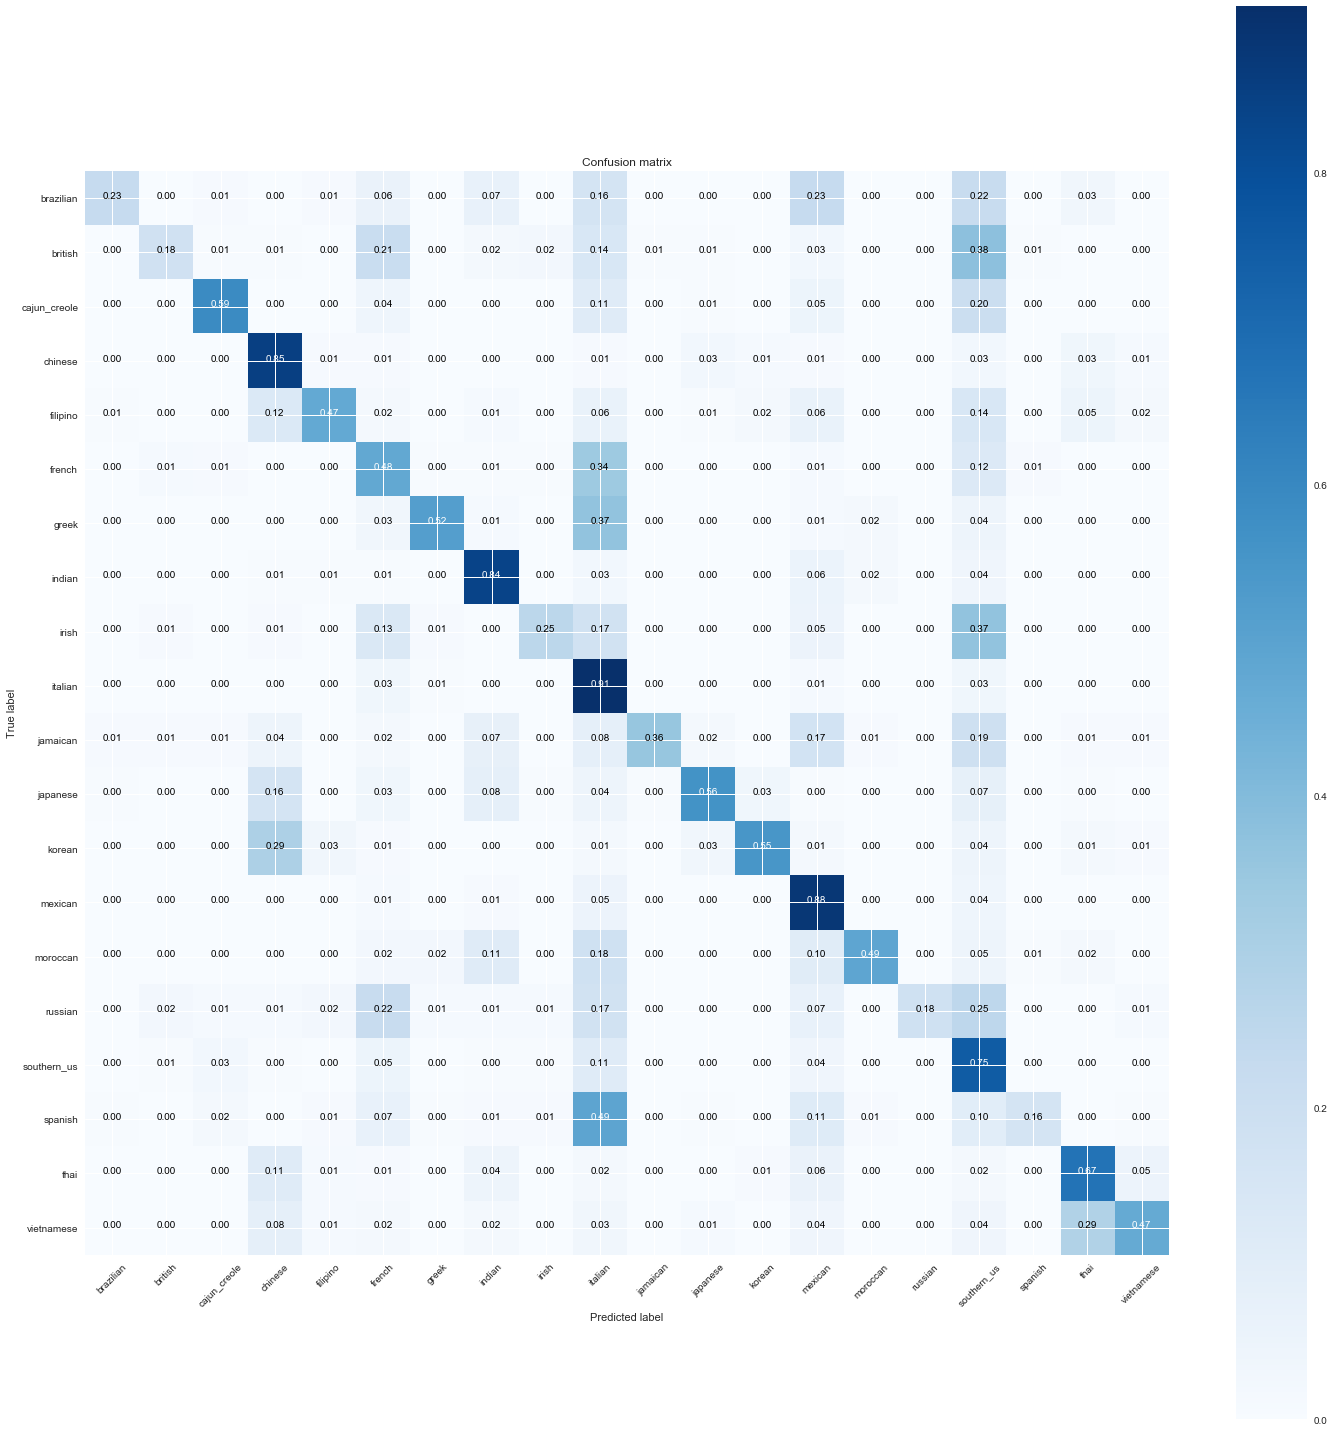

In [91]:
from sklearn.metrics import confusion_matrix
import sklearn

cnf_matrix = confusion_matrix(y_test.tolist(), yDecision_test.tolist())

print(sklearn.metrics.classification_report(y_test, yDecision_test))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=True, classes = labelEncoder.classes_)

plt.show()


In [ ]:
import numpy as np

# define the pipeline to prepare the data for simulate/apply
# return a data frame with a single row
def prepareDataForApply(ingredientSet):
    # vectorize
    row = list()
    for ingr in uniqueTrainIngredients:
        row.append(1if ingr in ingredientSet else 0)
    result = pd.DataFrame([row], columns=uniqueTrainIngredients) 
    # apply tf-idf
    result = tfIdf.transform(result)
    # apply pca
    result = pca.transform(result.toarray())
    result = pd.DataFrame(result)
    #result.rename(axis='columns', inplace=True, mapper=lambda x: "f" + str(x))
    return result

# Open Your Fridge

<img src="images/fridge.png" width="150">

Tell me what you have in your fridge, i will tell you if the mixture is eatable !

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, IntSlider

sortedUniqueTrainIngredients = sorted(uniqueTrainIngredients)
ingrWidget1 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 1',
    disabled=False
)

ingrWidget2 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 2',
    disabled=False
)

ingrWidget3 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 3',
    disabled=False
)

ingrWidget4 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 4',
    disabled=False
)

button = widgets.Button(
    description='Indigestion?',
    disabled=False,
    tooltip='Estimate Indigestion Level'
)

res = widgets.HTML(
    value="Hello <b>World</b>",
)

file = open("images/danger.png", "rb")
image = file.read()

danger_image = widgets.Image(
    value=image,
    format='png',
    width=50,
    height=50
)

file = open("images/safe.png", "rb")
image = file.read()
safe_image = widgets.Image(
    value=image,
    format='png',
    width=50,
    height=50
)

countryImages = dict()
countryFileNames = {
'brazilian':'br',
'british':'gb',
'cajun_creole':'us',
'chinese':'cn',
'filipino': 'ph',
'french':'fr',
'greek':'gr',
'indian':'in',
'irish':'ie',
'italian':'it',
'jamaican':'jm',
'japanese':'jp',
'korean':'kr',
'mexican':'mx',
'moroccan':'ma',
'russian': 'ru',
'southern_us': 'us',
'spanish' : 'es',
'thai':'th',
'vietnamese':'vn'
}

for country in labelEncoder.classes_:
    file = open("images/" + countryFileNames[country] + ".png", "rb")
    countryImages[country] = file.read()

country_image = widgets.Image(
    value=countryImages['vietnamese'],
    format='png'
)

country_label = widgets.Label(
)

slider = IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,    
    disable=True)

hbox = HBox([danger_image, slider, safe_image])
hbox2 = HBox([country_image, country_label])

def onChange(change):
    try:
        selectedIngredients = set()
        if len(ingrWidget1.value) > 0:
            selectedIngredients.add(ingrWidget1.value)
        if len(ingrWidget2.value) > 0:
            selectedIngredients.add(ingrWidget2.value)
        if len(ingrWidget3.value) > 0:
            selectedIngredients.add(ingrWidget3.value)
        if len(ingrWidget4.value) > 0:
            selectedIngredients.add(ingrWidget4.value)

        testData = prepareDataForApply(selectedIngredients)

        probas = classifier.predict_proba(testData)
        indexMax = np.argmax(probas)
        maxProba=probas.max()
        mostProbableCountry = labelEncoder.inverse_transform([indexMax])[0] 

        # update widgets
        country_label.value = mostProbableCountry
        country_image.value = countryImages[mostProbableCountry]
        slider.value = np.rint(maxProba * 100.)
    except Exception as e:
        country_label.value = str(e)
    
    return

ingrWidget1.observe(onChange)
ingrWidget2.observe(onChange)
ingrWidget3.observe(onChange)
ingrWidget4.observe(onChange)

display(ingrWidget1)
display(ingrWidget2)
display(ingrWidget3)
display(ingrWidget4)

display(hbox)
display(hbox2)